# Phân loại ảnh ung thư da (Skin Cancer Detection)

## Dự án Capstone - HAM10000 Dataset

Mục tiêu:
- Binary Classification: Melanoma (ác tính) vs Benign (lành tính)
- Multi-class Classification: 7 loại bệnh da liễu

---



In [1]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)
import warnings
import os
warnings.filterwarnings('ignore')

# Cấu hình hiển thị
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Đã import các thư viện thành công!")



Đã import các thư viện thành công!


## 1. Đọc và khám phá dữ liệu



In [2]:

# Đọc file metadata
try:
    df = pd.read_csv('../data/HAM10000_metadata.csv')
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file!")

print(f"Kích thước dữ liệu: {df.shape}")
print(f"\nCác cột trong dataset:")
print(df.columns.tolist())
print(f"\nThông tin cơ bản về dataset:")
print(df.info())

Kích thước dữ liệu: (10015, 7)

Các cột trong dataset:
['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization']

Thông tin cơ bản về dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB
None


In [3]:
print(f"\nThống kê mô tả chi tiết hơn (mean, median, std cho các cột số):")
print(df.describe())


Thống kê mô tả chi tiết hơn (mean, median, std cho các cột số):
               age
count  9958.000000
mean     51.863828
std      16.968614
min       0.000000
25%      40.000000
50%      50.000000
75%      65.000000
max      85.000000


In [4]:
# Kiểm tra giá trị thiếu (missing values)
print("Số lượng giá trị thiếu trong mỗi cột:")
print(df.isnull().sum())
print(f"\nTỷ lệ giá trị thiếu:")
print((df.isnull().sum() / len(df)) * 100)



Số lượng giá trị thiếu trong mỗi cột:
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

Tỷ lệ giá trị thiếu:
lesion_id       0.000000
image_id        0.000000
dx              0.000000
dx_type         0.000000
age             0.569146
sex             0.000000
localization    0.000000
dtype: float64


Phân bố các loại chẩn đoán:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

Tổng số loại chẩn đoán: 7


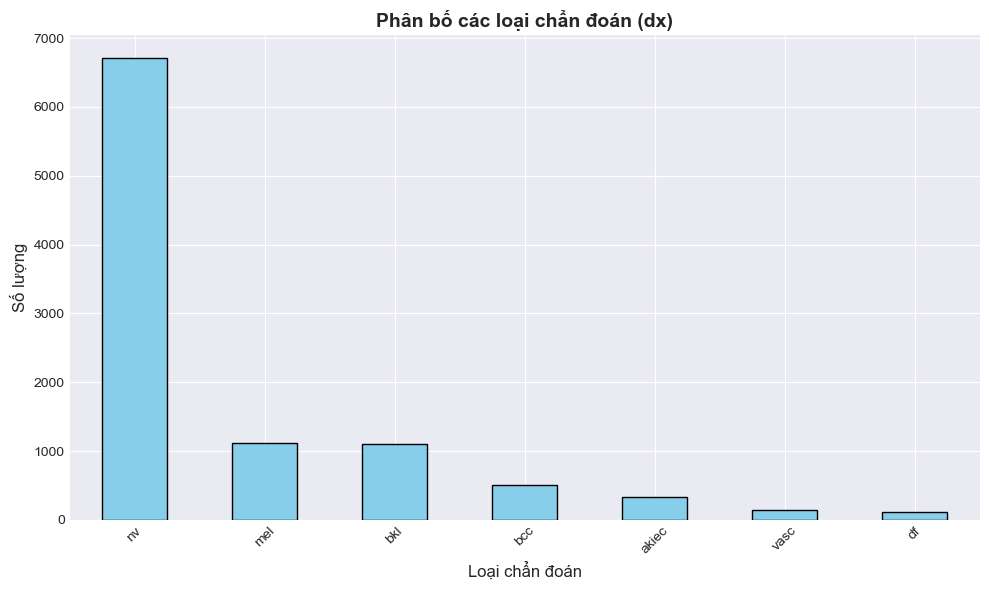

In [5]:
# Phân bố các loại chẩn đoán (dx)
print("Phân bố các loại chẩn đoán:")
print(df['dx'].value_counts())
print(f"\nTổng số loại chẩn đoán: {df['dx'].nunique()}")

# Hiển thị biểu đồ phân bố
plt.figure(figsize=(10, 6))
df['dx'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Phân bố các loại chẩn đoán (dx)', fontsize=14, fontweight='bold')
plt.xlabel('Loại chẩn đoán', fontsize=12)
plt.ylabel('Số lượng', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



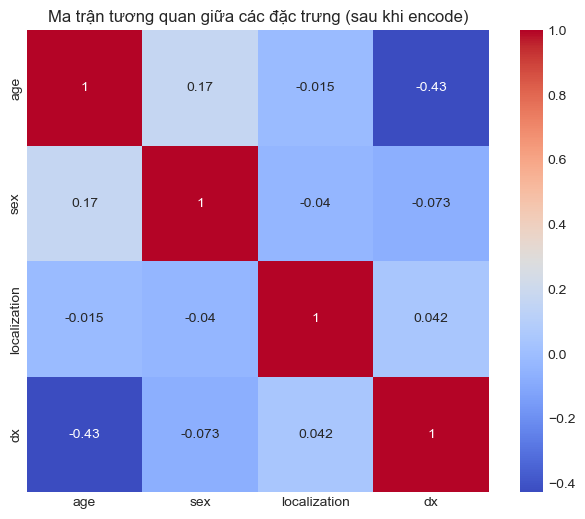

In [6]:
# Ma trận tương quan giữa các đặc trưng (sau khi encode)
df_corr = df.copy()
for col in ['sex', 'localization', 'dx']:
    le = LabelEncoder()
    df_corr[col] = le.fit_transform(df_corr[col].astype(str))

corr = df_corr[['age', 'sex', 'localization', 'dx']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', square=True)
plt.title('Ma trận tương quan giữa các đặc trưng (sau khi encode)')
plt.show()


## 2. Tiền xử lý dữ liệu

### 2.1. Xử lý missing values với SimpleImputer



In [7]:
# Tạo bản sao để xử lý
df_processed = df.copy()

# Kiểm tra giá trị thiếu trong từng cột
print(f"Số giá trị thiếu trong từng cột:")
print(df_processed.isnull().sum())

# Xử lý missing values cho cột age (số)
imputer_age = SimpleImputer(strategy='median')
df_processed['age'] = imputer_age.fit_transform(df_processed[['age']]).flatten()

print(f"Số giá trị thiếu sau khi xử lý:")
df_processed.isnull().sum()



Số giá trị thiếu trong từng cột:
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64
Số giá trị thiếu sau khi xử lý:


lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [8]:
# Xử lý missing values cho các cột categorical (sex, localization)
imputer_sex = SimpleImputer(strategy='most_frequent')
df_processed['sex'] = imputer_sex.fit_transform(df_processed[['sex']]).flatten()

imputer_localization = SimpleImputer(strategy='most_frequent')
df_processed['localization'] = imputer_localization.fit_transform(
    df_processed[['localization']]
).flatten()

print("Đã xử lý xong missing values cho tất cả các cột!")
print(f"\nSố giá trị thiếu còn lại: {df_processed.isnull().sum().sum()}")



Đã xử lý xong missing values cho tất cả các cột!

Số giá trị thiếu còn lại: 0


### 2.2. Mapping cột dx thành diagnosis theo yêu cầu



In [9]:
# Mapping dx thành diagnosis
# Theo yêu cầu: không có mapping cụ thể trong đề, nhưng ta sẽ giữ nguyên dx
# và tạo cột diagnosis cho binary classification
dx_dict = {
    'bkl': 'benign_keratosis',
    'nv': 'melanocytic_nevus',
    'df': 'dermatofibroma',
    'mel': 'melanoma',
    'bcc': 'basal_cell_carcinoma',
    'akiec': 'actinic_keratosis',
    'vasc': 'vascular_lesion'
}

df_processed['diagnosis'] = df_processed['dx'].map(dx_dict)

print("Mapping dx thành diagnosis:")
print(df_processed[['dx', 'diagnosis']].head(10))
print(f"\nPhân bố diagnosis:")
print(df_processed['diagnosis'].value_counts())



Mapping dx thành diagnosis:
    dx         diagnosis
0  bkl  benign_keratosis
1  bkl  benign_keratosis
2  bkl  benign_keratosis
3  bkl  benign_keratosis
4  bkl  benign_keratosis
5  bkl  benign_keratosis
6  bkl  benign_keratosis
7  bkl  benign_keratosis
8  bkl  benign_keratosis
9  bkl  benign_keratosis

Phân bố diagnosis:
diagnosis
melanocytic_nevus       6705
melanoma                1113
benign_keratosis        1099
basal_cell_carcinoma     514
actinic_keratosis        327
vascular_lesion          142
dermatofibroma           115
Name: count, dtype: int64


### 2.3. Chuẩn bị dữ liệu cho Binary Classification (Melanoma vs Benign)

---

**Quy tắc phân loại:**
- **Label B = 1 (Ác tính)**: melanoma (mel), basal cell carcinoma (bcc), actinic keratoses (akiec), vascular lesions (vasc)
- **Label M = 0 (Lành tính)**: nevus (nv), dermatofibroma (df), benign keratosis-like (bkl)

---



In [10]:
# Tạo label cho binary classification
# Ác tính (Malignant) = 1: mel, bcc, akiec, vasc
# Lành tính (Benign) = 0: nv, df, bkl

malignant_types = ['mel', 'bcc', 'akiec', 'vasc']
benign_types = ['nv', 'df', 'bkl']

df_processed['binary_label'] = df_processed['dx'].apply(
    lambda x: 1 if x in malignant_types else 0
)

print("Phân bố binary labels:")
print(df_processed['binary_label'].value_counts())
print(f"\nTỷ lệ:")
print(df_processed['binary_label'].value_counts(normalize=True) * 100)



Phân bố binary labels:
binary_label
0    7919
1    2096
Name: count, dtype: int64

Tỷ lệ:
binary_label
0    79.071393
1    20.928607
Name: proportion, dtype: float64


### 2.4. Encode các biến phân loại và chuẩn hóa dữ liệu



In [11]:
# Encode các biến categorical
label_encoder_sex = LabelEncoder()
label_encoder_localization = LabelEncoder()
label_encoder_dx = LabelEncoder()  # Cho multi-class classification

df_processed['sex_encoded'] = label_encoder_sex.fit_transform(df_processed['sex'])
df_processed['localization_encoded'] = label_encoder_localization.fit_transform(
    df_processed['localization']
)
df_processed['dx_encoded'] = label_encoder_dx.fit_transform(df_processed['dx'])

print("Đã encode các biến categorical!")
print(f"\nSex mapping: {dict(zip(label_encoder_sex.classes_, range(len(label_encoder_sex.classes_))))}")
print(f"\nDx mapping (cho multi-class):")
for i, class_name in enumerate(label_encoder_dx.classes_):
    print(f"  {class_name}: {i}")



Đã encode các biến categorical!

Sex mapping: {'female': 0, 'male': 1, 'unknown': 2}

Dx mapping (cho multi-class):
  akiec: 0
  bcc: 1
  bkl: 2
  df: 3
  mel: 4
  nv: 5
  vasc: 6


## 2.6. Drop các cột thừa

In [12]:
df_processed = df_processed.drop(columns=['lesion_id', 'image_id', 'dx_type'])
df_processed.head()


,dx,age,sex,localization,diagnosis,binary_label,sex_encoded,localization_encoded,dx_encoded
0,bkl,80.0,male,scalp,benign_keratosis,0,1,11,2
1,bkl,80.0,male,scalp,benign_keratosis,0,1,11,2
2,bkl,80.0,male,scalp,benign_keratosis,0,1,11,2
3,bkl,80.0,male,scalp,benign_keratosis,0,1,11,2
4,bkl,75.0,male,ear,benign_keratosis,0,1,4,2


## 3. Binary Classification: Melanoma vs Benign

### 3.1. Chuẩn bị dữ liệu cho Binary Classification



In [13]:
# Chọn các features cho binary classification
features_binary = ['age', 'sex_encoded', 'localization_encoded']
X_binary = df_processed[features_binary].copy()
y_binary = df_processed['binary_label'].copy()

print(f"Shape của X_binary: {X_binary.shape}")
print(f"Shape của y_binary: {y_binary.shape}")
print(f"\nPhân bố y_binary:")
print(y_binary.value_counts())



Shape của X_binary: (10015, 3)
Shape của y_binary: (10015,)

Phân bố y_binary:
binary_label
0    7919
1    2096
Name: count, dtype: int64


In [14]:
# Chuẩn hóa dữ liệu với StandardScaler
scaler_binary = StandardScaler()
X_binary_scaled = scaler_binary.fit_transform(X_binary)
X_binary_scaled = pd.DataFrame(
    X_binary_scaled,
    columns=features_binary,
    index=X_binary.index
)

print("Đã chuẩn hóa dữ liệu!")
print(f"\nThống kê sau khi chuẩn hóa:")
print(X_binary_scaled.describe())



Đã chuẩn hóa dữ liệu!

Thống kê sau khi chuẩn hóa:
                age   sex_encoded  localization_encoded
count  1.001500e+04  1.001500e+04          1.001500e+04
mean  -1.163545e-16  2.270331e-17          1.078407e-16
std    1.000050e+00  1.000050e+00          1.000050e+00
min   -3.064613e+00 -1.083518e+00         -1.469256e+00
25%   -7.005454e-01 -1.083518e+00         -1.047960e+00
50%   -1.095285e-01  8.823210e-01          4.265751e-01
75%    7.769970e-01  8.823210e-01          1.058519e+00
max    1.959031e+00  2.848160e+00          1.479814e+00


In [15]:
# Chia tập train và test (80-20)
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
    X_binary_scaled,
    y_binary,
    test_size=0.2,
    random_state=42,
    stratify=y_binary
)

print(f"Train set: {X_train_binary.shape[0]} mẫu")
print(f"Test set: {X_test_binary.shape[0]} mẫu")
print(f"\nPhân bố y_train_binary:")
print(y_train_binary.value_counts())
print(f"\nPhân bố y_test_binary:")
print(y_test_binary.value_counts())



Train set: 8012 mẫu
Test set: 2003 mẫu

Phân bố y_train_binary:
binary_label
0    6335
1    1677
Name: count, dtype: int64

Phân bố y_test_binary:
binary_label
0    1584
1     419
Name: count, dtype: int64


### 3.2. Huấn luyện mô hình SVM cho Binary Classification



In [16]:
# Huấn luyện SVM cho binary classification
svm_binary = SVC(kernel='rbf', random_state=42, probability=True, class_weight='balanced')
print("Đang huấn luyện mô hình SVM (Binary Classification)...")
svm_binary.fit(X_train_binary, y_train_binary)
print("Hoàn thành huấn luyện!")



Đang huấn luyện mô hình SVM (Binary Classification)...
Hoàn thành huấn luyện!


### 3.3. Đánh giá mô hình Binary Classification



In [17]:
# Dự đoán trên tập test
y_pred_binary = svm_binary.predict(X_test_binary)

# Tính accuracy
accuracy_binary = accuracy_score(y_test_binary, y_pred_binary)
print(f"Accuracy: {accuracy_binary:.4f} ({accuracy_binary*100:.2f}%)")



Accuracy: 0.6930 (69.30%)


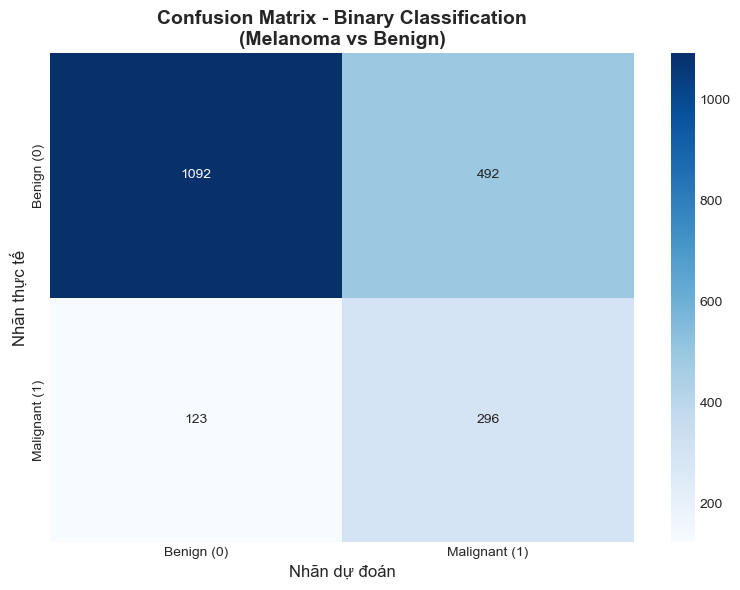


Confusion Matrix:
[[1092  492]
 [ 123  296]]


In [18]:
# Confusion Matrix với heatmap
cm_binary = confusion_matrix(y_test_binary, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_binary,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Benign (0)', 'Malignant (1)'],
    yticklabels=['Benign (0)', 'Malignant (1)']
)
plt.title('Confusion Matrix - Binary Classification\n(Melanoma vs Benign)', 
          fontsize=14, fontweight='bold')
plt.ylabel('Nhãn thực tế', fontsize=12)
plt.xlabel('Nhãn dự đoán', fontsize=12)
plt.tight_layout()
plt.show()

print("\nConfusion Matrix:")
print(cm_binary)



In [19]:
# Classification Report
print("Classification Report - Binary Classification:")
print("=" * 60)
print(classification_report(
    y_test_binary,
    y_pred_binary,
    target_names=['Benign (0)', 'Malignant (1)']
))



Classification Report - Binary Classification:
               precision    recall  f1-score   support

   Benign (0)       0.90      0.69      0.78      1584
Malignant (1)       0.38      0.71      0.49       419

     accuracy                           0.69      2003
    macro avg       0.64      0.70      0.64      2003
 weighted avg       0.79      0.69      0.72      2003



## 4. Multi-class Classification: 7 loại bệnh da liễu

### 4.1. Chuẩn bị dữ liệu cho Multi-class Classification

---

**7 loại bệnh:**
- nv: melanocytic nevus
- mel: melanoma
- bkl: benign keratosis-like lesion
- bcc: basal cell carcinoma
- akiec: actinic keratosis
- vasc: vascular lesion
- df: dermatofibroma

---



In [20]:
# Sử dụng cùng các features như binary classification
features_multiclass = ['age', 'sex_encoded', 'localization_encoded']
X_multiclass = df_processed[features_multiclass].copy()
y_multiclass = df_processed['dx_encoded'].copy()

print(f"Shape của X_multiclass: {X_multiclass.shape}")
print(f"Shape của y_multiclass: {y_multiclass.shape}")
print(f"\nPhân bố các lớp trong y_multiclass:")
print(y_multiclass.value_counts().sort_index())
print(f"\nTên các lớp:")
for i, class_name in enumerate(label_encoder_dx.classes_):
    print(f"  {i}: {class_name}")



Shape của X_multiclass: (10015, 3)
Shape của y_multiclass: (10015,)

Phân bố các lớp trong y_multiclass:
dx_encoded
0     327
1     514
2    1099
3     115
4    1113
5    6705
6     142
Name: count, dtype: int64

Tên các lớp:
  0: akiec
  1: bcc
  2: bkl
  3: df
  4: mel
  5: nv
  6: vasc


In [21]:
# Chuẩn hóa dữ liệu
scaler_multiclass = StandardScaler()
X_multiclass_scaled = scaler_multiclass.fit_transform(X_multiclass)
X_multiclass_scaled = pd.DataFrame(
    X_multiclass_scaled,
    columns=features_multiclass,
    index=X_multiclass.index
)

print("Đã chuẩn hóa dữ liệu cho multi-class classification!")



Đã chuẩn hóa dữ liệu cho multi-class classification!


In [22]:
# Chia tập train và test (80-20)
X_train_multiclass, X_test_multiclass, y_train_multiclass, y_test_multiclass = train_test_split(
    X_multiclass_scaled,
    y_multiclass,
    test_size=0.2,
    random_state=42,
    stratify=y_multiclass
)

print(f"Train set: {X_train_multiclass.shape[0]} mẫu")
print(f"Test set: {X_test_multiclass.shape[0]} mẫu")
print(f"\nPhân bố y_train_multiclass:")
print(y_train_multiclass.value_counts().sort_index())
print(f"\nPhân bố y_test_multiclass:")
print(y_test_multiclass.value_counts().sort_index())



Train set: 8012 mẫu
Test set: 2003 mẫu

Phân bố y_train_multiclass:
dx_encoded
0     262
1     411
2     879
3      92
4     890
5    5364
6     114
Name: count, dtype: int64

Phân bố y_test_multiclass:
dx_encoded
0      65
1     103
2     220
3      23
4     223
5    1341
6      28
Name: count, dtype: int64


### 4.2. Huấn luyện mô hình SVM cho Multi-class Classification



In [23]:
# Huấn luyện SVM cho multi-class classification với class_weight để xử lý class imbalance
svm_multiclass = SVC(
    kernel='rbf',
    random_state=42,
    probability=True,
    class_weight='balanced'  # Tự động cân bằng trọng số cho các lớp
)
print("Đang huấn luyện mô hình SVM (Multi-class Classification)...")
print("Sử dụng class_weight='balanced' để xử lý class imbalance")
svm_multiclass.fit(X_train_multiclass, y_train_multiclass)
print("Hoàn thành huấn luyện!")



Đang huấn luyện mô hình SVM (Multi-class Classification)...
Sử dụng class_weight='balanced' để xử lý class imbalance


Hoàn thành huấn luyện!


### 4.3. Đánh giá mô hình Multi-class Classification



In [24]:
# Dự đoán trên tập test
y_pred_multiclass = svm_multiclass.predict(X_test_multiclass)

# Tính accuracy
accuracy_multiclass = accuracy_score(y_test_multiclass, y_pred_multiclass)
print(f"Accuracy: {accuracy_multiclass:.4f} ({accuracy_multiclass*100:.2f}%)")



Accuracy: 0.3070 (30.70%)


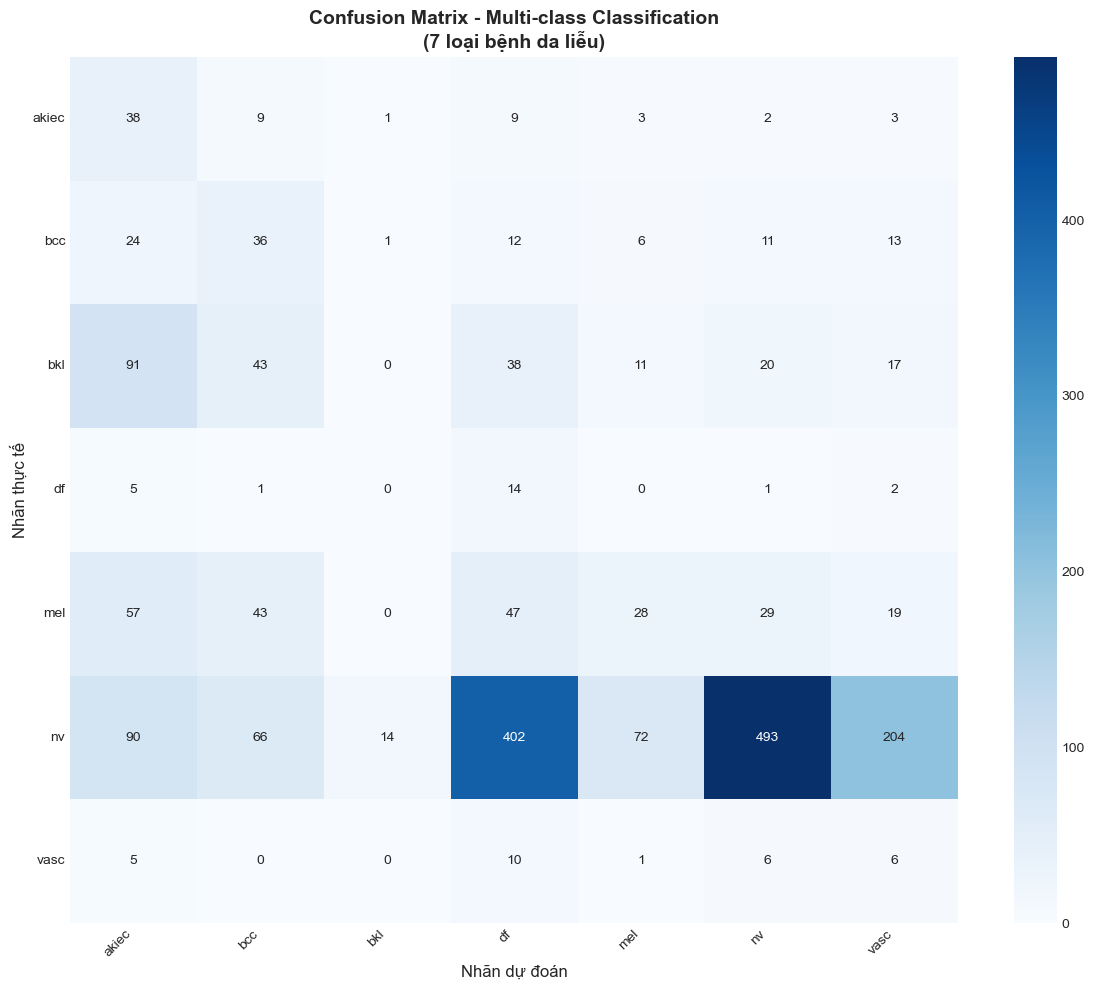


Confusion Matrix:
[[ 38   9   1   9   3   2   3]
 [ 24  36   1  12   6  11  13]
 [ 91  43   0  38  11  20  17]
 [  5   1   0  14   0   1   2]
 [ 57  43   0  47  28  29  19]
 [ 90  66  14 402  72 493 204]
 [  5   0   0  10   1   6   6]]


In [25]:
# Confusion Matrix với heatmap cho multi-class
cm_multiclass = confusion_matrix(y_test_multiclass, y_pred_multiclass)

# Lấy tên các lớp
class_names = label_encoder_dx.classes_

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_multiclass,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title('Confusion Matrix - Multi-class Classification\n(7 loại bệnh da liễu)', 
          fontsize=14, fontweight='bold')
plt.ylabel('Nhãn thực tế', fontsize=12)
plt.xlabel('Nhãn dự đoán', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nConfusion Matrix:")
print(cm_multiclass)



In [26]:
# Classification Report cho từng lớp
print("Classification Report - Multi-class Classification:")
print("=" * 70)
print(classification_report(
    y_test_multiclass,
    y_pred_multiclass,
    target_names=class_names
))



Classification Report - Multi-class Classification:
              precision    recall  f1-score   support

       akiec       0.12      0.58      0.20        65
         bcc       0.18      0.35      0.24       103
         bkl       0.00      0.00      0.00       220
          df       0.03      0.61      0.05        23
         mel       0.23      0.13      0.16       223
          nv       0.88      0.37      0.52      1341
        vasc       0.02      0.21      0.04        28

    accuracy                           0.31      2003
   macro avg       0.21      0.32      0.17      2003
weighted avg       0.63      0.31      0.39      2003



## 5. Tóm tắt kết quả



In [27]:
# Tạo bảng tóm tắt kết quả
results_summary = pd.DataFrame({
    'Mô hình': ['Binary Classification', 'Multi-class Classification'],
    'Accuracy': [accuracy_binary, accuracy_multiclass],
    'Số lớp': [2, 7],
    'Số mẫu train': [len(y_train_binary), len(y_train_multiclass)],
    'Số mẫu test': [len(y_test_binary), len(y_test_multiclass)]
})

print("=" * 70)
print("TÓM TẮT KẾT QUẢ")
print("=" * 70)
print(results_summary.to_string(index=False))
print("\n")

print("Chi tiết Binary Classification:")
print(f"  - Accuracy: {accuracy_binary:.4f} ({accuracy_binary*100:.2f}%)")
print(f"  - Lớp 0 (Benign): nv, df, bkl")
print(f"  - Lớp 1 (Malignant): mel, bcc, akiec, vasc")
print("\n")

print("Chi tiết Multi-class Classification:")
print(f"  - Accuracy: {accuracy_multiclass:.4f} ({accuracy_multiclass*100:.2f}%)")
print(f"  - 7 loại bệnh: {', '.join(class_names)}")



TÓM TẮT KẾT QUẢ
                   Mô hình  Accuracy  Số lớp  Số mẫu train  Số mẫu test
     Binary Classification  0.692961       2          8012         2003
Multi-class Classification  0.307039       7          8012         2003


Chi tiết Binary Classification:
  - Accuracy: 0.6930 (69.30%)
  - Lớp 0 (Benign): nv, df, bkl
  - Lớp 1 (Malignant): mel, bcc, akiec, vasc


Chi tiết Multi-class Classification:
  - Accuracy: 0.3070 (30.70%)
  - 7 loại bệnh: akiec, bcc, bkl, df, mel, nv, vasc


## 6. Lưu mô hình và các thành phần đã huấn luyện

Lưu lại mô hình, scaler và encoder để có thể tái sử dụng sau này.



In [28]:
# Import joblib để lưu model
import joblib
import os

# Tạo thư mục models nếu chưa có
os.makedirs('../models', exist_ok=True)

try:
    # Lưu Binary Classification model và các thành phần
    joblib.dump(svm_binary, '../models/svm_binary.pkl')
    joblib.dump(scaler_binary, '../models/scaler_binary.pkl')
    joblib.dump(label_encoder_sex, '../models/label_encoder_sex.pkl')
    joblib.dump(label_encoder_localization, '../models/label_encoder_localization.pkl')
    
    # Lưu Multi-class Classification model và các thành phần
    joblib.dump(svm_multiclass, '../models/svm_multiclass.pkl')
    joblib.dump(scaler_multiclass, '../models/scaler_multiclass.pkl')
    joblib.dump(label_encoder_dx, '../models/label_encoder_dx.pkl')
    
    print("✅ Đã lưu thành công tất cả các mô hình và thành phần!")
    print("\nCác file đã lưu:")
    print("  - ../models/svm_binary.pkl")
    print("  - ../models/scaler_binary.pkl")
    print("  - ../models/svm_multiclass.pkl")
    print("  - ../models/scaler_multiclass.pkl")
    print("  - ../models/label_encoder_sex.pkl")
    print("  - ../models/label_encoder_localization.pkl")
    print("  - ../models/label_encoder_dx.pkl")
    
except Exception as e:
    print(f"❌ Lỗi khi lưu model: {e}")



✅ Đã lưu thành công tất cả các mô hình và thành phần!

Các file đã lưu:
  - ../models/svm_binary.pkl
  - ../models/scaler_binary.pkl
  - ../models/svm_multiclass.pkl
  - ../models/scaler_multiclass.pkl
  - ../models/label_encoder_sex.pkl
  - ../models/label_encoder_localization.pkl
  - ../models/label_encoder_dx.pkl


### Ví dụ sử dụng lại mô hình đã lưu:

```python
# Load model đã lưu
svm_binary_loaded = joblib.load('../models/svm_binary.pkl')
scaler_binary_loaded = joblib.load('../models/scaler_binary.pkl')

# Chuẩn hóa dữ liệu mới
X_new_scaled = scaler_binary_loaded.transform(X_new)

# Dự đoán
y_pred_new = svm_binary_loaded.predict(X_new_scaled)
```

